# PC Lab 6: Regularization Methods 
---

We have already seen linear regression to tackle regression problems. With linear regression, we model a continous outcome as a linear function of the features:

$$\hat{y} = w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p} = \sum\limits_{i=0}^{p}w_{i}x_{i}.$$

This works well when there are a lot of training observations and when the number of features (the dimensionality of the problem) is not too large. However, there are a couple of situations where ordinary linear regression might give problems:

* When the number of features $p$ becomes large with respect to the number of observations $n$, the variance of the model weights estimated by linear regression increases, which might result in poor predictive performance. Futhermore, there is no longer an analytical solution provided by least squares when $p > n$.
* It is possible that there are a lot of uninteresting or redundant features. If we want a sparse and interpretable model, we might want to do feature selection to reduce $p$.

In this lab, we will cover two solutions to the problems above: subset selection and regularization methods.

## 1. Subset selection methods

In subset selection, we only use a subset of the features that are available. The goal is to come up with a model that is sparse and that generalizes better to unseen data. There are two main strategies for subset selection: in *best subset selection*, we fit all the $p \choose k$ models for each $k = 1, 2, ..., p$ and retain the best model for each $k$. Finally, we select the model that performs best on some measure that controls for overfitting:

![bestsubset](https://raw.githubusercontent.com/gdewael/teaching/main/predmod/lab6/img/best_subset.png)

This becomes quickly unfeasible for large values of $p$. Therefore, an alternative approach is to perform *stepwise selection*, which explores a much smaller set of feature combinations. Stepwise selection can be performed either backward or forward. 

![forward](https://raw.githubusercontent.com/gdewael/teaching/main/predmod/lab6/img/forward.png)

Finally, it is important to account for the fact that the MSE (or, equivalently, the RSS) will always go down on the training data as we add more and more features. To select the best model out of several candidates, it is important to have an estimate of the test error of each model. This can be done indirectly by using a metric that penalizes for model complexity such as the AIC or the adjusted $R^2$. Another option is to use cross-validation to get an estimate of the test error.

**Let's apply subset selection on two datasets.** The first dataset contains features of mixtures used to produce concrete. The goal is to predict the compressive strength of the concrete.

In [1]:
!wget https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/concreteComprStrength.txt
!wget https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/fc_data_new.csv
!wget https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/communities.csv

--2024-01-26 15:40:36--  https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/concreteComprStrength.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58994 (58K) [text/plain]
Saving to: ‘concreteComprStrength.txt.1’

concreteComprStreng 100%[===================>]  57,61K  --.-KB/s    in 0,01s   

2024-01-26 15:40:37 (3,93 MB/s) - ‘concreteComprStrength.txt.1’ saved [58994/58994]

--2024-01-26 15:40:37--  https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/fc_data_new.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

200 OK
Length: 414077 (404K) [text/plain]
Saving to: ‘fc_data_new.csv.1’

fc_data_new.csv.1   100%[===================>] 404,37K  --.-KB/s    in 0,08s   

2024-01-26 15:40:37 (4,71 MB/s) - ‘fc_data_new.csv.1’ saved [414077/414077]

--2024-01-26 15:40:37--  https://raw.githubusercontent.com/BioML-UGent/MLLS/main/06_regularization/communities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1091499 (1,0M) [text/plain]
Saving to: ‘communities.csv.1’

communities.csv.1   100%[===================>]   1,04M  6,81MB/s    in 0,2s    

2024-01-26 15:40:38 (6,81 MB/s) - ‘communities.csv.1’ saved [1091499/1091499]



In [2]:
# Read in the data
import pandas as pd

concretedata = pd.read_table('concreteComprStrength.txt', delim_whitespace=True, header=0, index_col=None)
# Extract features and label for later usage
X = concretedata.drop(['compressiveStrength'], axis=1)
y = concretedata['compressiveStrength']

print(concretedata.shape)
concretedata.head()

(1030, 9)


,cement,blastFurnaceSlag,flyAsh,water,superelastizer,coarseAggregate,fineAggregate,age,compressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Let's build up an intuition for the code we need for doing best subset selection with linear regression. We will implement Algorithm 6.1 as shown above. First we split the data and look at how we can generate all possible combinations of features:

In [3]:
from itertools import chain, combinations

list_of_features = ["ft.1", "ft.2", "ft.3"]
for subset in chain.from_iterable(combinations(list_of_features, r) for r in range(1, len(list_of_features)+1)):
    print(subset)

('ft.1',)
('ft.2',)
('ft.3',)
('ft.1', 'ft.2')
('ft.1', 'ft.3')
('ft.2', 'ft.3')
('ft.1', 'ft.2', 'ft.3')


Now we can use this code to iterate not through `list_of_features` but through the possible features. For every subset we fit a model and keep it in a dictionary that records the score for that specific subset of features:

In [4]:
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations

list_of_features = X.columns
scoring_dict = {}

for subset in chain.from_iterable(combinations(list_of_features, r) for r in range(1, len(list_of_features)+1)):
    X_subset = X[list(subset)]
    model = LinearRegression()
    model.fit(X_subset, y)
    scoring_dict[subset] = model.score(X_subset, y)

Taking five random samples from this dict to get an idea what's in it:

In [5]:
import random
random.sample(list(scoring_dict.items()), 5)

[(('cement', 'flyAsh', 'water', 'age'), 0.4534792511384278),
 (('blastFurnaceSlag', 'flyAsh', 'fineAggregate', 'age'), 0.13653353119094291),
 (('cement', 'blastFurnaceSlag', 'superelastizer', 'coarseAggregate'),
  0.42230807078022026),
 (('coarseAggregate', 'age'), 0.13503492787367477),
 (('flyAsh',), 0.011184102321051714)]

Getting the best model:

In [6]:
max(scoring_dict, key=scoring_dict.get), scoring_dict[max(scoring_dict, key=scoring_dict.get)]

(('cement',
  'blastFurnaceSlag',
  'flyAsh',
  'water',
  'superelastizer',
  'coarseAggregate',
  'fineAggregate',
  'age'),
 0.6155198704142721)

We see that the best model (R² score-wise) is the one where all features are present. However, this is estimated on training data, so it might very well be that this result is due to overfitting. To do this in a better way, we will use cross-validation, as seen in the previous practical. The following code block expands upon the previous code block with these things in mind: **This code may take a little while to run.**

In [7]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np


list_of_features = X.columns
scoring_dict = {}

#NEW:
# Define splitter object outside loop to ensure same splits over loop
splitter = KFold(n_splits=5, shuffle=True, random_state=None)
####

for subset in chain.from_iterable(combinations(list_of_features, r) for r in range(1, len(list_of_features)+1)):
    X_subset = X[list(subset)]
    model = LinearRegression()

    # NEW: instead of simply fitting the model on all train data,
    # now we use cross validation to fit and evaluate model
    # cross_validate() returns a dict with key 'test_score' containing
    # a list of  CV performances of every split
    scores = cross_validate(model, X_subset.values, y.values, cv=splitter)
    scoring_dict[subset] = np.mean(scores['test_score'])

Let's visualize how the test performance changes in function of how many features we had in the model:

Best feature combination: ('cement', 'blastFurnaceSlag', 'flyAsh', 'water', 'coarseAggregate', 'age')


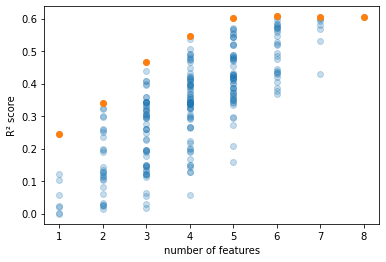

In [8]:
import matplotlib.pyplot as plt

plt.scatter([len(k) for k in scoring_dict.keys()], list(scoring_dict.values()), alpha = 0.25)
plt.xlabel('number of features')
plt.ylabel('R² score')
# taking the best model for every 'n' number of features and plotting them separately:
best_score_n = [
    max([v for k, v in scoring_dict.items() if len(k) == i])
    for i in range(1, X.shape[1]+1)
]
plt.scatter(range(1, X.shape[1]+1), best_score_n)
print('Best feature combination:', max(scoring_dict, key=scoring_dict.get))

We see that one certain combination of 5 features already results in a performance on +- the same level as the one with all features. This finding begs the question: could we have found this combination more efficiently, without testing out all possible feature combinations?

Now, we will introduce a second dataset. This time, the features are measurements from a flow cytometry experiment. The 'SC' features measure scatter, and say something about the morphologhy of the cells (FSC: forwad scatter, SSC: sideway scatter). The 'FL' features are fluorescence features from different parts of the spectrum. There are two possible bacterial species present in the dataset. The goal is to classify the correct species based on the measurements from the flow cytometer. Species number one corresponds to *Pseudomonas putida*, while species number 6 is *Brachybacterium faecium*. We will use logistic regression to do the classification.

This dataset has 10 features instead of the 8 features encountered in the previous dataset. We could repeat the same *best subset selection* method, but this time we will implement *stepwise forward selection*.

In [9]:
# Read in the data
bacterialdata = pd.read_csv('fc_data_new.csv', index_col=0)
bacterialdata = bacterialdata.drop(['Width', 'Time'], axis=1).reset_index(drop=True)

In [10]:
bacterialdata.head()

,FSC-A,SSC-A,FL1-A,FL2-A,FL3-A,FL4-A,FSC-H,SSC-H,FL1-H,FL2-H,species
0,47325.0,11730.0,311772.0,70873.0,70379.0,0.0,55410.0,13649.0,208324.0,47062.0,6
1,15766.0,4417.0,285761.0,64624.0,50408.0,0.0,36950.0,8129.0,238931.0,52847.0,6
2,11206.0,3194.0,403584.0,96978.0,73632.0,18.0,33761.0,4810.0,358999.0,86278.0,6
3,33577.0,5558.0,258064.0,52010.0,35322.0,0.0,72014.0,10396.0,226185.0,44847.0,1
4,5525.0,2417.0,348457.0,64062.0,33637.0,1525.0,19074.0,5938.0,304335.0,55864.0,6


<div class="alert alert-success">

<b>EXERCISE 1.1</b>: **Complete the code below that implements forward stepwise selection.**
</div>  

Text(0, 0.5, 'accuracy')

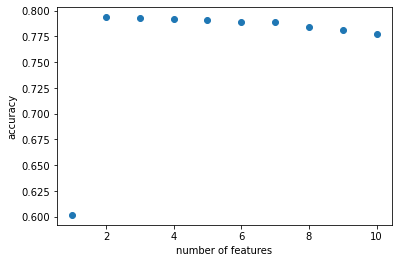

In [11]:
from sklearn.linear_model import LogisticRegression

X = bacterialdata.drop(['species'], axis=1)
y = bacterialdata['species']
scoring_dict = {}
splitter = KFold(n_splits=5, shuffle=True, random_state=None)

features_already_in_model = set()
features_not_in_model = set(X.columns)

# iterate through the numbers of features that we can add at every step
for k in np.arange(1, X.shape[1] + 1):
    # at every step: iterate through the features that we can still add
    # keep a separate scoring dictionary for features added at this step:
    scoring_dict_k = {}
    for feature in features_not_in_model:
        # select the previously added features + a feature to (maybe) add
        X_subset = X[list(features_already_in_model) + [feature]]
        model = LogisticRegression(max_iter = 1000)
        scores = cross_validate(model, X_subset.values, y.values, cv=splitter)
        scoring_dict_k[feature] = np.mean(scores['test_score'])

    feature_to_add = max(scoring_dict_k, key=scoring_dict_k.get)
    features_already_in_model.add(feature_to_add)
    features_not_in_model.remove(feature_to_add)
    scoring_dict[tuple(features_already_in_model)] = max(scoring_dict_k.values())

import matplotlib.pyplot as plt

plt.scatter([len(k) for k in scoring_dict.keys()], list(scoring_dict.values()))
plt.xlabel('number of features')
plt.ylabel('accuracy')

In [12]:
for k, v in scoring_dict.items():
    print(k, v)

('FL2-H',) 0.60175
('FL1-H', 'FL2-H') 0.7935
('FL1-H', 'FL3-A', 'FL2-H') 0.7925
('FL1-H', 'FL2-A', 'FL3-A', 'FL2-H') 0.792
('FL2-A', 'FL2-H', 'FSC-A', 'FL3-A', 'FL1-H') 0.7905
('FL2-A', 'FL2-H', 'SSC-A', 'FSC-A', 'FL3-A', 'FL1-H') 0.7885000000000001
('FL2-A', 'FL2-H', 'SSC-A', 'FSC-A', 'FL3-A', 'FL1-H', 'SSC-H') 0.7887500000000001
('FL1-A', 'FL2-A', 'FL2-H', 'SSC-A', 'FSC-A', 'FL3-A', 'FL1-H', 'SSC-H') 0.784
('FL1-A', 'FL2-A', 'FL2-H', 'SSC-A', 'FL4-A', 'FSC-A', 'FL3-A', 'FL1-H', 'SSC-H') 0.7809999999999999
('FL1-A', 'FL2-A', 'FL2-H', 'SSC-A', 'FL4-A', 'FSC-A', 'FL3-A', 'FSC-H', 'FL1-H', 'SSC-H') 0.7769999999999999


## 2. Regularization methods: ridge and lasso regression


Ridge and lasso regression are regularization techniques commonly employed in regression analysis to address the issue of overfitting. Overfitting occurs when a model learns the training data too well, capturing noise and leading to poor generalization on unseen data. Ridge regression adds a regularization term to the cost function (i.e. MSE), which penalizes large coefficients, encouraging the model to prioritize a simpler, smoother solution:

$$\sum_{i=1}^{n}\Big(y_{i}-\sum_{j=0}^{p}w_{j}x_{ij}\Big)^{2}\quad\text{subject to}\quad\sum_{j=1}^{p}w_{j}^{2}=s.$$

Lasso regression, on the other hand, uses a similar regularization approach but penalizes the absolute values of the coefficients: 

$$\sum_{i=1}^{n}\Big(y_{i}-\sum_{j=0}^{p}w_{j}x_{ij}\Big)^{2}\quad\text{subject to}\quad\sum_{j=1}^{p}|w_{j}|=s.$$

The key distinction is that lasso regression can also induce sparsity, effectively setting some coefficients to zero, leading to feature selection. By adding these regularization terms, ridge and lasso regression help prevent overfitting by constraining the model's complexity, making it more robust and improving its performance on new, unseen data.

### Linear models for high dimensional data

We will apply ridge regression on the Communities and Crime Data Set. The dataset contains 123 population statistics on 1994 communities. We would like to predict the number of violent crimes per 100000 inhabitants. This is the final column of the dataframe. Of the 123 features, a lot contain missing values, so we will drop these columns and use only 99 features:

In [13]:
import pandas as pd
import numpy as np

data = pd.read_csv('./communities.csv')

# Drop columns with missing values
data = data.dropna(axis=1)
print(data.shape)
data.head()

(1994, 100)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


<div class="alert alert-success">

<b>EXERCISE 2.1</b>: **Use linear regression and ridge regression to predict the number of violent crimes per 100,000 inhabitants. Use 5-fold cross-validation to evaluate both models. The [_RidgeCV_](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) class in Scikit-learn automatically performs cross-validation to tune the hyperparameter that determines the amount of regularization, so you don't need to implement a second cross-validation loop. Which model performs best?**
</div>  

**Before we apply ridge regression, it's important to make sure that all the features are on the same scale. If one of the features is on a completely different scale (let's say, income can be measured in dollars or in thousands of dollars), this might lead the ridge regression coefficient to change substantially because of the penalty term in the optimization problem. We can make sure that all the features are on the same scale by means of standardization:**

$$\tilde{x}_{ij} = \frac{x_{ij}-\bar{x}_{j}}{\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_{ij} - \bar{x}_{j})^2}}.$$

We can do this with the [_StandardScaler_](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class in Scikit-learn. We will do the scaling each time in the cross-validation loop using only training data statistics (*do you still remember why we only use training statistics to do this?*).

In [14]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [15]:
# ** solution

# Select X and y
y = data['ViolentCrimesPerPop'].values
X = data.drop(['ViolentCrimesPerPop'], axis=1).values

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-3,3,100))

    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))

    ridgemodel.fit(X_train, y_train)
    print('Regularization parameter: {}'.format(ridgemodel.alpha_))
    ridge_scores.append(ridgemodel.score(X_test,y_test))


print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))

# ** solution

Regularization parameter: 26.560877829466893
Regularization parameter: 35.111917342151344
Regularization parameter: 40.37017258596558
Regularization parameter: 53.366992312063125
Regularization parameter: 26.560877829466893
Average validation fold R² of linear regression: 0.647667941596117
Average validation fold R² of ridge regression: 0.6556882222065827


Now suppose that we don't have 99 features, but four times as many features. And suppose that a lot of features are correlated. This situation is very common in lots of datasets. We will mimic this situation by adding correlated features to our original feature matrix:

In [16]:
X_1 = X + np.random.normal(loc=0, scale=0.05, size=(X.shape))
X_2 = X + np.random.normal(loc=0, scale=0.1, size=(X.shape))
X_3 = X + np.random.normal(loc=0, scale=0.01, size=(X.shape))
X_expanded = np.concatenate((X, X_1, X_2, X_3), axis=1)

X_expanded.shape

(1994, 396)

<div class="alert alert-success">

<b>EXERCISE 2.2</b>: **Repeat the comparison between ridge regression and linear regression from above, but with the new feature matrix that contains correlated features. What happens with the performance of linear regression? What happens with the regularization parameter?**
</div>  

In [17]:
# ** solution

kf = KFold(n_splits=5)

linreg_scores = []
ridge_scores = []

for train_index, test_index in kf.split(X_expanded):
    X_train, X_test = X_expanded[train_index], X_expanded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    linregmodel = LinearRegression()
    ridgemodel = RidgeCV(alphas=np.logspace(-4,4,100))

    linregmodel.fit(X_train, y_train)
    linreg_scores.append(linregmodel.score(X_test,y_test))

    ridgemodel.fit(X_train, y_train)
    print('Regularization parameter: {}'.format(ridgemodel.alpha_))
    ridge_scores.append(ridgemodel.score(X_test,y_test))


print('Average validation fold R² of linear regression: {}'.format(np.mean(linreg_scores)))
print('Average validation fold R² of ridge regression: {}'.format(np.mean(ridge_scores)))
# ** solution

Regularization parameter: 422.9242874389508
Regularization parameter: 613.5907273413176
Regularization parameter: 1291.5496650148852
Regularization parameter: 890.2150854450392
Regularization parameter: 422.9242874389508
Average validation fold R² of linear regression: 0.5798545663416499
Average validation fold R² of ridge regression: 0.6473060252725977


### Lasso regression and feature selection

Suppose that we are interested in selecting only a couple of features out of a high dimensional dataset. Let's fit ridge regression and lasso regression on the data and look at the model coefficients for both models:

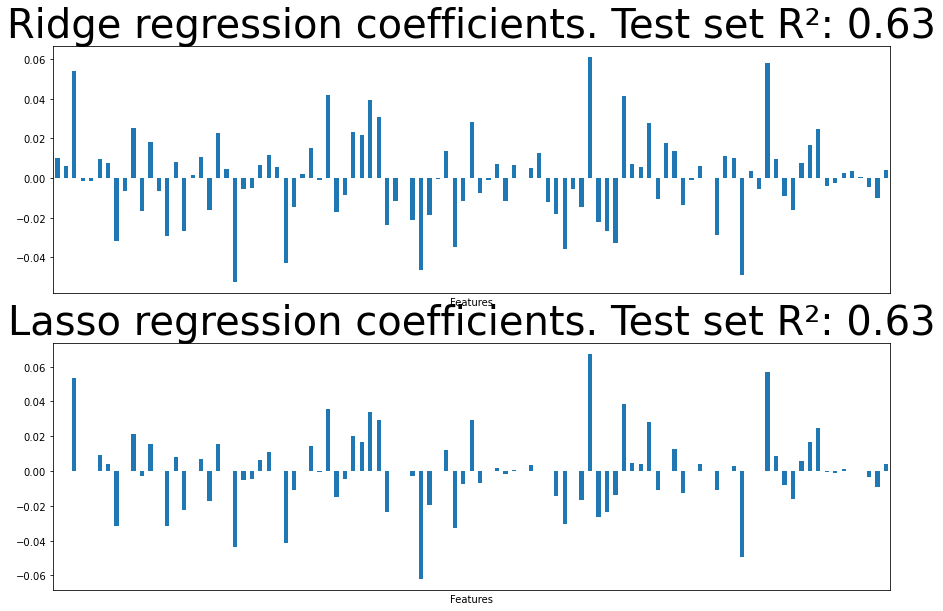

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

ridgemodel = RidgeCV(cv=5)
lassomodel = LassoCV(cv=5, max_iter=10000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridgemodel.fit(X_train, y_train)
ridgescore = np.round(ridgemodel.score(X_test, y_test),2)
lassomodel.fit(X_train, y_train)
lassoscore = np.round(lassomodel.score(X_test, y_test),2)

# Plot of the coefficients for ridge regression
fig, ((ax1, ax2)) = plt.subplots(figsize=(15, 10), nrows=2)
pd.Series(ridgemodel.coef_).plot(kind='bar', ax=ax1)
ax1.set_title('Ridge regression coefficients. Test set R²: {}'.format(ridgescore)).set_fontsize(40)
ax1.get_xaxis().set_ticks([])
ax1.set_xlabel('Features')

# Plot of the coefficients for the lasso
pd.Series(lassomodel.coef_).plot(kind='bar', ax=ax2)
ax2.set_title('Lasso regression coefficients. Test set R²: {}'.format(lassoscore)).set_fontsize(40)
ax2.get_xaxis().set_ticks([])
ax2.set_xlabel('Features');

The lasso applies regularization by constraining the sum of the absolute values of the model coefficients (the L1-norm). A result of this is that a lot of model coefficients are set to zero: the lasso performs **feature selection**. This is not the case for ridge regression: the model weights are rarely set to zero. Feature selection is a nice property if we want an interpretable model. Let's list the features with non-zero coefficients in the lasso:

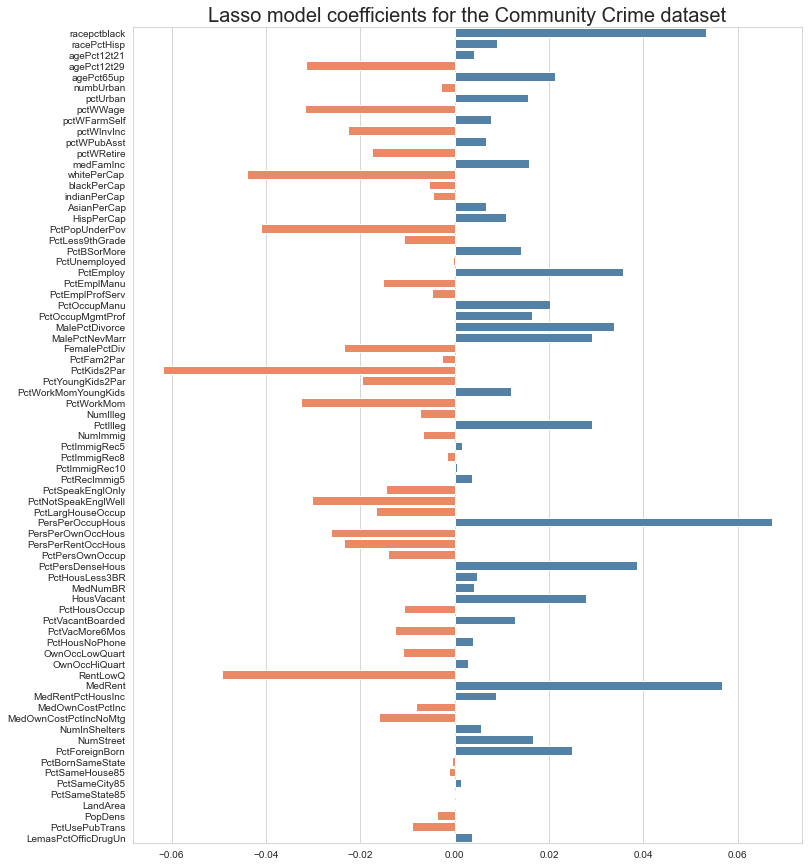

In [19]:
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(12,15))
sns.barplot(x= pd.Series(lassomodel.coef_[lassomodel.coef_ != 0]),
            y=data.drop(['ViolentCrimesPerPop'], axis=1).columns[lassomodel.coef_ != 0],
            palette=['steelblue' if n > 0 else 'coral' for n in lassomodel.coef_[lassomodel.coef_ != 0]],
            ax=ax);
ax.set_title('Lasso model coefficients for the Community Crime dataset').set_fontsize(20);